In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Preparing and loading training data...


100%|██████████| 340/340 [04:37<00:00,  1.23it/s]


Done Preparing training data...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 16)         0   

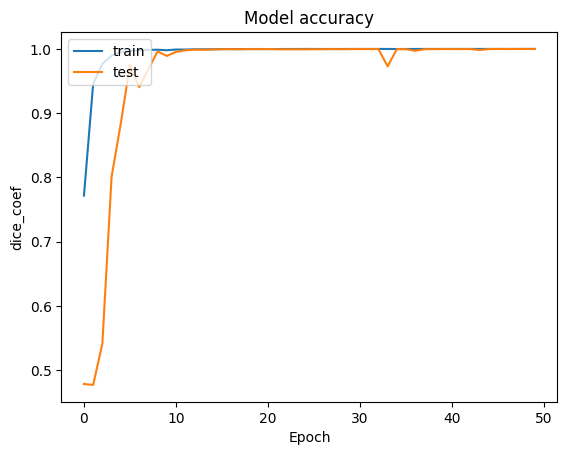

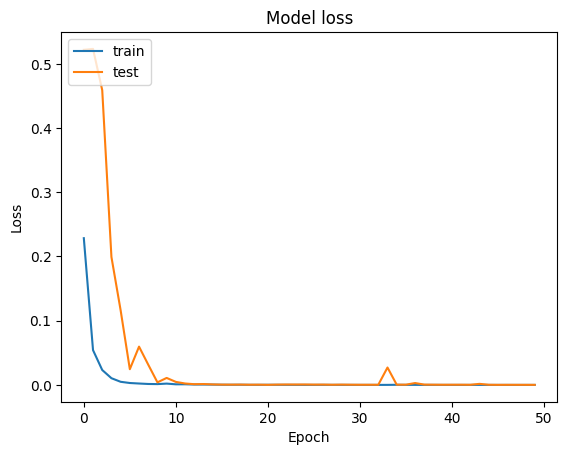

Preparing testing data...


100%|██████████| 320/320 [04:27<00:00,  1.20it/s]


64/64 [==============================] - 3s 37ms/step
Calculating metrics...


Calculating y_test: 100%|██████████| 320/320 [00:20<00:00, 15.35it/s]


              precision    recall  f1-score   support

         0.0       0.81      0.75      0.78  11067890
         1.0       0.74      0.80      0.77   9903630

    accuracy                           0.77  20971520
   macro avg       0.77      0.77      0.77  20971520
weighted avg       0.78      0.77      0.77  20971520

mIoU: 0.6304332057205846


100%|██████████| 320/320 [00:42<00:00,  7.49it/s]


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import os
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, Input
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import tensorflow as tf
import os
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, Input
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Accuracy, Precision, Recall
import os

def lab_split(I):
    I = cv2.cvtColor(I, cv2.COLOR_BGR2LAB)
    I = I.astype(np.float32)
    I1, I2, I3 = cv2.split(I)
    I1 /= 2.55
    I2 -= 128.0
    I3 -= 128.0
    return I1, I2, I3

def merge_back(I1, I2, I3):
    I1 *= 2.55
    I2 += 128.0
    I3 += 128.0
    I = np.clip(cv2.merge((I1, I2, I3)), 0, 255).astype(np.uint8)
    return cv2.cvtColor(I, cv2.COLOR_LAB2BGR)

def get_mean_std(I):
    I1, I2, I3 = lab_split(I)
    m1, sd1 = cv2.meanStdDev(I1)
    m2, sd2 = cv2.meanStdDev(I2)
    m3, sd3 = cv2.meanStdDev(I3)
    means = m1, m2, m3
    stds = sd1, sd2, sd3
    return means, stds

def Reinhard_method(target,I):
    means, stds = get_mean_std(target)
    target_means = means
    target_stds = stds
    I1, I2, I3 = lab_split(I)
    means, stds = get_mean_std(I)
    norm1 = ((I1 - means[0]) * (target_stds[0] / stds[0])) + target_means[0]
    norm2 = ((I2 - means[1]) * (target_stds[1] / stds[1])) + target_means[1]
    norm3 = ((I3 - means[2]) * (target_stds[2] / stds[2])) + target_means[2]
    return merge_back(norm1, norm2, norm3)

def calculateClass(img,n_labels,h,w):
    lab=np.zeros([h,w])
    for i in range (h):
        for j in range (w):
            b=img[i][j][0]
            g=img[i][j][1]
            r=img[i][j][2]
            if b==229 and g==155 and r==3:
                lab[i][j]=0
            else:
                lab[i][j]=1
    return lab

def create_label(img, dims,h,w,n_labels=2):
    labels=calculateClass(img,n_labels,h,w)
    x1 = np.zeros([dims[0], dims[1], n_labels])
    for i in range(dims[0]):
        for j in range(dims[1]):
            v1=int(labels[i][j])
            x1[i][j][v1]=1
    x1 = x1.reshape(dims[0] , dims[1], n_labels)
    return x1

def Calculate_metrics(test_image, gt, h, w):
    size = len(test_image)
    h, w, _ = np.shape(test_image[0])
    y_pred = np.zeros((h * w * size, 1))
    y_test = np.zeros((h * w * size, 1))

    res_img = []

    for q in tqdm(range(size), desc="Processing images"):
        img11 = test_image[q]
        img = np.zeros((h, w, 3))
        for i in range(h):
            for j in range(w):
                c1 = img11[i][j][0]
                c2 = img11[i][j][1]
                if c1 > c2:
                    img[i][j] = [0, 0, 0]
                else:
                    img[i][j] = [255, 255, 255]
        res_img.append(img)

    res_img = np.array(res_img)
    c = 0

    for i in tqdm(range(size), desc="Calculating y_pred"):
        img = res_img[i]
        for j in range(h):
            for l in range(w):
                b = img[j][l][0]
                if b == 0:
                    y_pred[c][0] = 0
                else:
                    y_pred[c][0] = 1
                c += 1

    c = 0

    for i in tqdm(range(size), desc="Calculating y_test"):
        img = gt[i]
        for j in range(h):
            for l in range(w):
                b = img[j][l][0]
                if b == 0:
                    y_test[c][0] = 0
                else:
                    y_test[c][0] = 1
                c += 1

    print(classification_report(y_test, y_pred))

    conf_mat = confusion_matrix(y_test, y_pred, labels=[0, 1])
    tp = np.diag(conf_mat)
    fp = np.sum(conf_mat, axis=0) - tp
    fn = np.sum(conf_mat, axis=1) - tp
    iou = tp / (tp + fp + fn + 1e-10)
    miou = np.mean(iou)

    print('mIoU:', miou)
    return

def dice_coef(y_true, y_pred):
    numerator = 2 * K.sum(y_true * y_pred, axis=(1, 2, 3))
    denominator = K.sum(y_true, axis=(1, 2, 3)) + K.sum(y_pred, axis=(1, 2, 3))
    dice_loss = 1 - (numerator + 1) / (denominator + 1)
    return dice_loss

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def Prepare_data(path_train, path_gt, h, w, n_labels=2):
    target = cv2.imread("/content/drive/MyDrive/Colab_Notebooks/BHI_dataset/Target.png")
    imgs = []
    labels = []

    files_train = os.listdir(path_train)
    files_gt = os.listdir(path_gt)

    base_files_train = set([os.path.splitext(file)[0] for file in files_train])
    base_files_gt = set([os.path.splitext(file)[0] for file in files_gt])

    matching_files = list(set(base_files_train).intersection(base_files_gt))

    for file_base in tqdm(matching_files):
        original_img = cv2.imread(os.path.join(path_train, file_base + ".png"))
        mask = cv2.imread(os.path.join(path_gt, file_base + ".png"))

        resized_img = cv2.resize(original_img, (h, w))
        cn_img = Reinhard_method(target, resized_img)
        array_img = img_to_array(cn_img) / 255
        imgs.append(array_img)

        mask = cv2.resize(mask, (h, w))
        array_mask = create_label(mask, (h, w),h,w,2)
        labels.append(array_mask)
    imgs = np.array(imgs)
    labels = np.array(labels)
    return imgs, labels, matching_files

# RESNET
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)

    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)

    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)

    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)

    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

def ResUNet(image_size,lr):
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))

    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)

    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)

    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])

    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])

    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])

    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])

    outputs = keras.layers.Conv2D(2, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    adam = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef])
    model.summary()
    return model

if __name__ == "__main__":
    path_train='/content/drive/MyDrive/Colab_Notebooks/BHI_dataset/Gt/'
    path_gt='/content/drive/MyDrive/Colab_Notebooks/BHI_dataset/Img/'

    h=256
    w=256
    lr=0.0001

    print("Preparing and loading training data...")
    X,Y,filenames = Prepare_data(path_train,path_gt,h,w)
    print("Done Preparing training data...")

    nb_epoch = 50
    batch = 5
    n_labels = 2
    model=ResUNet(h,lr)

    print('Model Compiled: OK.....')
    print("Opening model...")
    history=model.fit(x=X,y=Y,batch_size=batch, epochs=nb_epoch, verbose=1,validation_split=0.2)
    print("Model Fitting done...")
    model.save_weights('Resnet.hdf5')
    model.load_weights('Resnet.hdf5')

    fig=plt.figure()
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('Model accuracy')
    plt.ylabel('dice_coef')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig.savefig("U-Net_dice_coef.png")
    # Summarize history for loss
    fig=plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig.savefig("U-Net_loss.png")

    path_test_gt='/content/drive/MyDrive/Colab_Notebooks/BHI_dataset/Img-test/'
    path_test='/content/drive/MyDrive/Colab_Notebooks/BHI_dataset/Gt-test/'
    print("Preparing testing data...")
    test_data,gt,filenames = Prepare_data(path_test,path_test_gt,h,w)
    output = model.predict(test_data,batch_size=batch, verbose=1)

    print("Calculating metrics...")
    Calculate_metrics(output,gt,h,w)

    for i in tqdm(range(len(test_data))):
        Write_output_path = "/content/drive/MyDrive/Colab_Notebooks/BHI_dataset/Resnet/Results_1/Img_" + filenames[i] + ".png"
        out = output[i]
        img = test_data[i]
        for j in range(h):
            for p in range(w):
                if out[j][p][0] > out[j][p][1]:
                    img[j][p] = [0, 0, 0]
                else:
                    img[j][p] = [255, 255, 255]

        cv2.imwrite(Write_output_path, img)